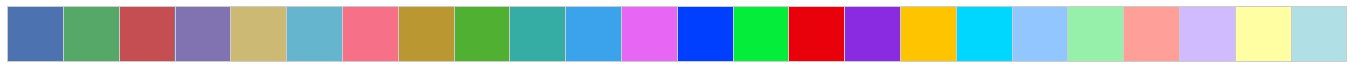

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
import utils
import scoring

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

In [15]:
data = pd.read_csv('data/train_part_1_v2.csv.gz', nrows=10000, na_values='-9999.0')
test = pd.read_csv('data/test_public_v2.csv.gz', na_values='-9999.0')

In [5]:
def cn(layer, dim): 
    return 'MatchedHit_%s[%d]' % (dim, layer)

def add_coses(train):    
    def v(layer, dim):
        return train[cn(layer, dim)] - train[cn(layer + 1, dim)]
    
    for i in range(1, 3):
        train[cn(i, 'DA')] = (v(i - 1, 'X') * v(i, 'X') + v(i - 1, 'Y') * v(i, 'Y') + v(i - 1, 'Z') * v(i, 'Z')) / \
                           np.sqrt(v(i - 1, 'X') ** 2 + v(i - 1, 'Y') ** 2 + v(i - 1, 'Z') ** 2) / \
                           np.sqrt(v(i, 'X') ** 2 + v(i, 'Y') ** 2 + v(i, 'Z') ** 2)
        train[cn(i, 'DACOS')] = np.arccos(train[cn(i, 'DA')]) / np.pi * 180

In [8]:
from sklearn.decomposition import PCA

def fill_na(data):    
    coord_cols = x_cols + y_cols + z_cols
    mask = data.loc[:, coord_cols].isna()
    means = data.mean(skipna=True)
    data.fillna(means, inplace=True)
    return mask

def restore_na(data, mask):
    data.mask(mask, other=np.NaN, inplace=True)

def add_pca(data, pca_model=None):
    mask = fill_na(data)
    
    if pca_model is None:
        pca_model = PCA(n_components=3)
        pca_model.fit(data.loc[:, [x_cols[0], y_cols[0], z_cols[0]]])

    for i in range(4):
        data.loc[:, [x_cols[i], y_cols[i], z_cols[i]]] = pca_model.transform(data.loc[:, [x_cols[i], y_cols[i], z_cols[i]]])

    restore_na(data, mask)
    return pca_model

In [16]:
data_simple_cols = data.loc[:, utils.SIMPLE_FEATURE_COLUMNS]
data_target_cols = data.loc[:, utils.TRAIN_COLUMNS]

x_cols = ['MatchedHit_X[%i]' % i for i in range(utils.N_STATIONS)]
y_cols = ['MatchedHit_Y[%i]' % i for i in range(utils.N_STATIONS)]
z_cols = ['MatchedHit_Z[%i]' % i for i in range(utils.N_STATIONS)]

pca_model = add_pca(data_simple_cols)
add_coses(data_simple_cols)

C:\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':


In [17]:
%%time
import xgboost as xgb

estimator = xgb.XGBClassifier(n_estimators=10)
estimator.fit(data_simple_cols.values, data_target_cols.label.values, sample_weight=data_target_cols.weight.values)

Wall time: 403 ms


In [ ]:
add_pca(test, pca_model)
add_coses(test)

In [ ]:
predictions = estimator.predict_proba(test.values)[:, 1]

In [ ]:
pd.DataFrame(data={"prediction": predictions}, index=test.index).to_csv(
    "out/01_baseline_w_pca_cos.csv", index_label=utils.ID_COLUMN)